# Messenger Learning

In this notebook, we will reference the data that has been gathered in our `Messenger Analysis` notebook to run machine learning algorithms. We will grab that data from the `dataframe.csv` file and store it as a Pandas DataFrame object. This dataframe lists the messages in my facebook messenger history, as well as information about each message. Here is a reminder of what this dataframe contains:

### Message meta data
* **sender_name**         - the name of the sender who sent the message
* **timestamp_ms**        - the timestamp at which the message was sent, YYYY-MM-DD HH:MM:SS.SSSSSS
* **content**             - the text of the message
* **conversation**        - the name of the JSON file containing the conversation; unique to each chat
* **reactions**           - reactions to the message

### Message date / time

* **year**                - the year component of the timestamp
* **month**               - the month component of the timestamp
* **day**                 - the day component of the timestamp
* **date**                - the full date of the timestamp
* **time**                - the time of the timestamp

### Sender data

* **major**               - the undergraduate major of the sender
* **meeting place**       - the school in which I met the sender
* **meeting semester**    - the semester when I met the sender
* **meeting**             - the place and semester where/when I met the sender
* **lives in**            - the location where the sender lives (NYC, Long Island, International)
* **entered_college**     - the semester when the sender entered college
* **academic standing**   - the academic standing of the sender at the time of the message
* **relative standing**   - how much academically older/younger the sender is than me

### Message analysis

* **sentiment**           - the sentiment of the message, on a -1 to 1 scale from worst to best, as determined by NLTK Vader
* **first message**       - indicates if the message is the first message sent by the sender
* **semester**            - the semester when the message was sent
* **length**              - the length of the message in characters
* **waited**              - timedelta since the previous message of the conversation has been sent
* **new talk**            - indicates if the message is the beginning of a new discussion in the conversation

In [74]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [75]:
df = pd.read_csv('dataframe.csv')

C:\Users\Denis\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Cleaning the data

We notice that two of our columns - **first message** and **new talk** - take on boolean values. We would like to transform them into numerical values of <br> `True = 1` and `False = 0` so that we could easily use these data features for machine learning algorithms.

In [76]:
df['first message'] = df['first message'].apply(int)
df['new talk']           = df['new talk'].apply(int)

Now let's look at **missing data** that might interfere with the execution of our machine learning algorithms. We can display the missing data as a heatmap that marks the `NaN` values from the dataframe in the numeric columns. We notice that there are a few messages missing sentiment.

`df[df['sentiment'].isna()]` can be used to show us that messages with missing sentiment have `NaN` content as well, so we can safely remove them from the dataframe.

We make sure to do this in a way that does not remove information about the beginning of a new discussion (or talk), so we check if the message that is deleted is a `new talk`, and if it is, we assign the message following it to be a new talk message.

<AxesSubplot:>

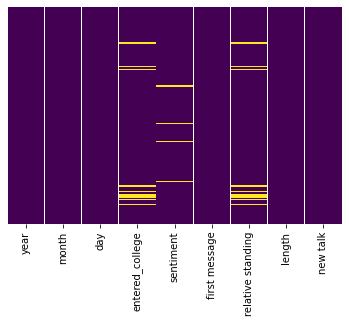

In [4]:
sns.heatmap(df.select_dtypes(['number']).isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [77]:
def set_talk(row):
    try:
        index = df.index[row]
        prev = df.iloc[index-1]
        if prev['sentiment'].isnull():
            if prev['new talk'] == 1:
                return 1
            else:
                return row['new talk']
        else:
            return row['new talk']
    except:
        return row['new talk']

df['new talk'] = df.apply(set_talk, axis=1)

df.drop(df[df['sentiment'].isnull()].index, inplace=True)                  # Dropping rows

C:\Users\Denis\anaconda3\lib\site-packages\pandas\core\indexes\base.py:4111: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


We notice that the `entered_college` and `relative standing` columns appear to be **missing values** in identical rows, which makes sense. We will make sure of this just in case there has been a data entry error. I compare the lengths of two dataframes below to ensure that the two columns are in fact missing values in the same rows.

In [6]:
#df[(df['entered_college'].isnull()) & (df['relative standing'].isnull())].info()

We can try to fill in this information by using **logistic regression**, but first we need to finish preprocessing our data. In order for the data to work with our machine learning algorithms, we would first like to convert the ***categorical features*** into dummy variables.

We will do this with the following features:

* year
* month
* major
* meeting place
* meeting semester
* lives in

In [78]:
year =             pd.get_dummies(df['year'])
month =            pd.get_dummies(df['month'], prefix='month_')
major =            pd.get_dummies(df['major'])
meeting_place =    pd.get_dummies(df['meeting place'], prefix='met_at_')
meeting_semester = pd.get_dummies(df['meeting semester'], prefix='meeting_semester_')
lives_in =         pd.get_dummies(df['lives in'], prefix='lives_in')

df.drop(['year', 'month', 'major', 'meeting place', 'meeting semester', 'lives in', 'meeting'], axis=1, inplace=True)

df = pd.concat([df, year, month, major, meeting_place, meeting_semester, lives_in], axis=1)

### Logistic regression

Now we can figure out when some of the contacts have entered college by using the **logistic regression** classification algorithm, based off of numeric features of the dataframe.

We will first test this algorithm on our known data, and then we will apply it to the `entered_college` data that we do not know.

In [8]:
#df_complete = df.drop(df[df['entered_college'].isnull()].index)
#df_unknown = df[df['entered_college'].isnull()]

df_complete = df.drop(['sender_name', 'content', 'reactions', 'academic standing', 'conversation', 'timestamp_ms', 'date', 'time', 'semester', 'waited', 'relative standing'], axis=1)
df_unknown  = df.drop(['sender_name', 'content', 'reactions', 'academic standing', 'conversation', 'timestamp_ms', 'date', 'time', 'semester', 'waited', 'relative standing'], axis=1)

df_complete.drop(df[df['entered_college'].isnull()].index, inplace=True)
df_unknown = df_unknown[df_unknown['entered_college'].isnull()]

In [79]:
from sklearn.model_selection import train_test_split

In [80]:
X_train, X_test, y_train, y_test = train_test_split(df_complete.drop('entered_college', axis=1), df_complete['entered_college'], test_size=0.3)

In [81]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

C:\Users\Denis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [12]:
predictions = logmodel.predict(X_test)

In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

C:\Users\Denis\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      2012.0       0.67      0.03      0.06        66
      2013.0       0.70      0.81      0.75      1282
      2014.0       0.79      0.62      0.70      1437
      2015.0       0.96      0.97      0.96     29774
      2016.0       0.94      0.88      0.91      5492
      2017.0       0.94      0.95      0.95      5931
      2018.0       0.75      0.84      0.79       140
      2020.0       0.00      0.00      0.00         2

    accuracy                           0.94     44124
   macro avg       0.72      0.64      0.64     44124
weighted avg       0.94      0.94      0.94     44124



The logistic regression model is accurate on the data that we already know. There is a lor of innacuracy for the year 2012, but the students whose `entered_college` values I do not know have all entered college after 2012. Let's now train a model on all of the data that we know and apply it to the `entered_college` values that we do not know.

In [82]:
logmodel.fit(df_complete.drop('entered_college', axis=1), df_complete['entered_college'])

predictions = logmodel.predict(df_unknown.drop('entered_college', axis=1))

C:\Users\Denis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [83]:
counter = 0

def set_entered(entered):
    if pd.isnull(entered):
        global counter
        counter += 1
        return predictions[counter-1]
    else:
        return entered

df['entered_college'] = df['entered_college'].apply(set_entered)

Now that we have imputed the values for `entered_college`, we can determine what the `relative standing` of the senders is. 

As we can then see, all of the values of the dataframe are known.

In [84]:
myYear = 2015

def set_relative(standing_and_entered):
    standing = standing_and_entered[0]
    entered  = standing_and_entered[1]
    
    if pd.isnull(standing):
        return myYear - int(entered)
    else:
        return standing

df['relative standing'] = df[['relative standing', 'entered_college']].apply(set_relative, axis=1)

<AxesSubplot:>

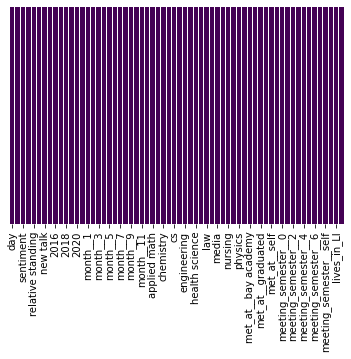

In [85]:
sns.heatmap(df.select_dtypes(['number']).isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Principal Component Analysis

Now that we have the data that we can use for the machine learning algorithms, let us see how we can reduce this data into **principal components**. We will discover two principal components that would allow us to easily visualize the data set. I make sure not to include my own messages in the data set.

In [86]:
my_name = 'Denis Rozhnov'

In [87]:
from sklearn.preprocessing import StandardScaler

In [90]:
scaler = StandardScaler()
scaler.fit(df.select_dtypes(np.number))

StandardScaler()

In [91]:
scaled_data = scaler.transform(df[df['sender_name'] != my_name].select_dtypes(np.number))

In [92]:
from sklearn.decomposition import PCA

In [93]:
pca = PCA(n_components=2)

In [94]:
pca.fit(scaled_data)

PCA(n_components=2)

In [95]:
x_pca = pca.transform(scaled_data)

Text(0, 0.5, 'Second Principal Component')

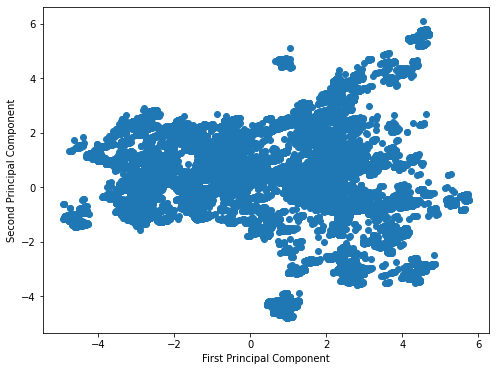

In [26]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

#### K-Means clustering

My data set now looks like a smiling octopus.

Now we can use **K-Means clustering** to identify two clusters in the data set. Further exploring the principal components will possibly allow us to identify the variable that most clearly partitions the data. We could then partition the data by that variable and compare the result with the K-Means clustering partition.

In [88]:
from sklearn.cluster import KMeans

In [89]:
kmeans = KMeans(n_clusters=2)

In [29]:
kmeans.fit(x_pca)

KMeans(n_clusters=2)

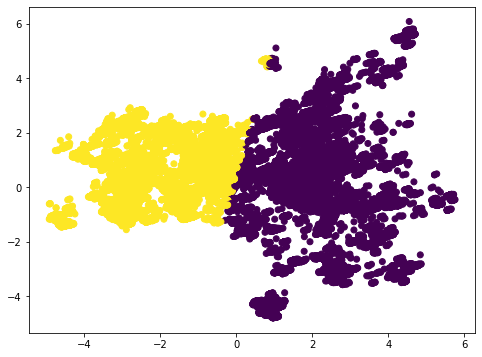

In [30]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1], c=kmeans.labels_)

The data is broken down into two clusters. The cluster at the right has more variance along the second principal component.

Let's use a heatmap to see how the two principal components correlate with each of the features of the data set.

In [96]:
df_comp = pd.DataFrame(pca.components_, columns=df.select_dtypes(np.number).columns)

<AxesSubplot:>

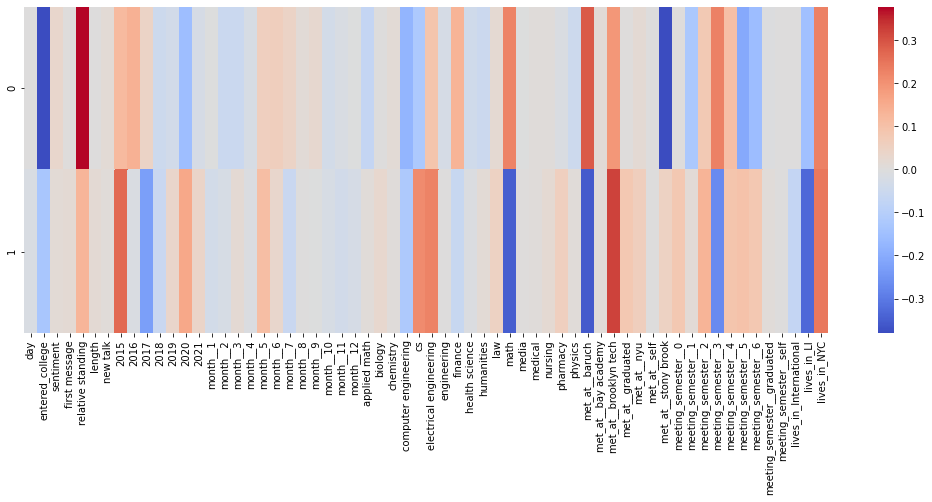

In [97]:
plt.figure(figsize=(18,6))
sns.heatmap(df_comp,cmap='coolwarm')

It appears that the two principal components most accurately capture the difference between my time at two different schools, Baruch College and Stony Brook University.

The **first principal component** (component 0) has a positive correlation with my communication with `math` and `finance` majors, as well as people I have `met_at__baruch`, while the **second principal component** (component 1) has a positive correlation with my communication with `cs` (computer science) majors , as well as people I have `met_at__stony brook` - this group has a distinctly negative correlation with component 0.

Component 0 also has a distrinctly negative correlation with the year when the sender of the message had `entered_college` and a distinctly positive correlation with the `relative standing` of the student, indicating that I have communicated more with older than younger students, who have correspondingly entered college earlier. This correlation almost dissapears for component 1, since I have stayed in touch with the older students, but also began to communicate more with the younger students when I transferred to Stony Brook.

You could also notice a trend of increasing correlation between year when message was sent and component 1, and decreasing correlation between year and component 0, as the years increase.

These components do not correspond directly to my time at different schools - for instance, component 1 positively correlates with messages sent in `2015`. The correlation of component 1 with `lives_in_LI` is lower than than the corresponding correlation of component 0 (althought the correlation with `lives_in_international` has slightly increased). However, the general tendency can be noted, so we can **hue the data** by `met_at__stony brook` values to comparethe resulting partition to the partition induced by K-Means clustering.

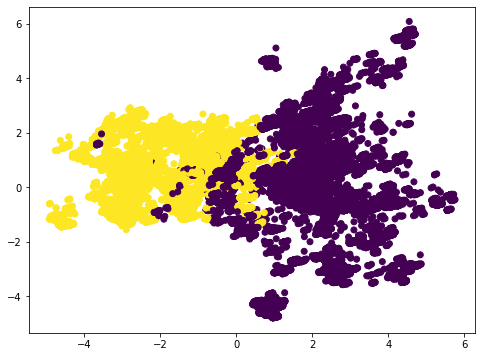

In [33]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1], c=df[df['sender_name'] != my_name]['met_at__stony brook'])

This partition does indeed resemble the partition induced by K-Means clustering. We can suppose that the **yellow points** correspond to the messages from students whom I have `met_at__stony brook`, since the **purple points** correlate higher with component 0, which we approximate as an indication of relationaship with Baruch.

Note that this strong correlation between `met_at__stony brook` and component 0 is captured in the heat map. A strong correlation can also be observed for `entered_college` or `relative standing` and component 0, although the values are not binary for those categories so there would be more than two clusters. The case of `entered_college` is illustrated below; here the correlation is negative, so as the year in whihc the student entered college increases, the x-coordinate (component 0) of the point decreases.

This is a trend, but it can be violated due to other features that are used in the computation of component 0 - thus there are green points to the left of the yellow points.

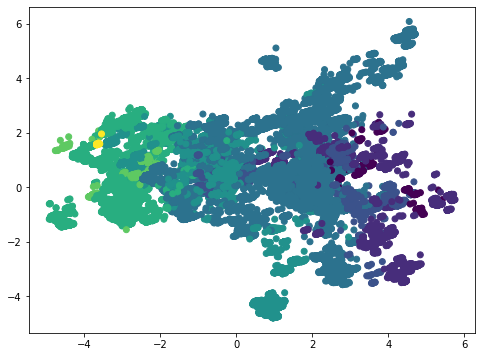

In [34]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1], c=df[df['sender_name'] != my_name]['entered_college'])

Now let's see what caused the high variance in the messages that are not from students whom I have `met_at__stony brook`. I suspect that this is caused by the variety of other locations at which I have met students.

We can check this by looking at the heat map. We can see that, indeed, `met_at__brooklyn tech` and `met_at__baruch` correlate strongly with component 1 - positively and negatively, respectively. This means that we should expect to see messages sent from Baruch students below messages sent from Brooklyn Tech students.

Here are the messages sent from Brooklyn Tech students and Baruch students, in that order. The group of interest is shown in **yellow**.

Text(0.5, 1.0, 'Met at Brooklyn Tech')

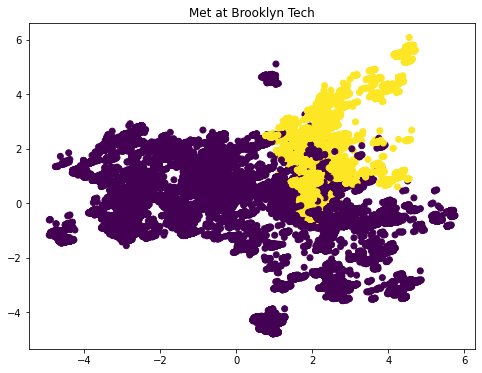

In [35]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1], c=df[df['sender_name'] != my_name]['met_at__brooklyn tech'])
plt.title('Met at Brooklyn Tech')

Text(0.5, 1.0, 'Met at Baruch College')

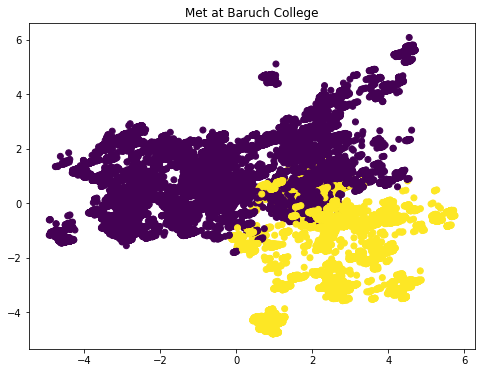

In [36]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1], c=df[df['sender_name'] != my_name]['met_at__baruch'])
plt.title('Met at Baruch College')

Several of the unclaimed points are attributed to messages sent from students whom I `met_at__nyu`.

Since these points have only a slight positive correlation with component 1, they are found near the middle of the vertical axis on the graph.

Text(0.5, 1.0, 'Met at NYU')

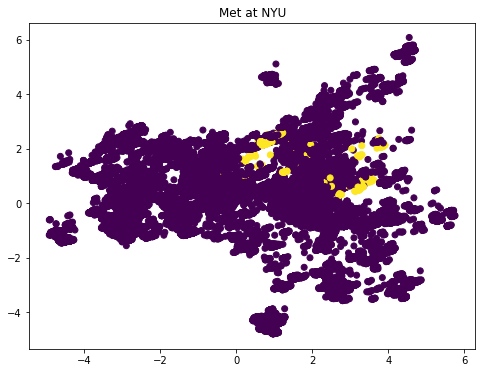

In [37]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1], c=df[df['sender_name'] != my_name]['met_at__nyu'])
plt.title('Met at NYU')

It appears that the x-axis here corresponds to some measure of relationship between the message metadata and Stony Brook / Long Island. The stratification of the y-axis appears to relate to where I met the sender (apart from Stony Brook, mostly relevant to the right side of the scatter plot), whether the sender majors in `math` and whether the sender lives on Long Island (the last two metrics could also cause variation in the y-values of the left side).

Now let's **decrease the size of the markers** and see if we can glean some additional insights into the structure of the messages.

Text(0, 0.5, 'Second Principal Component')

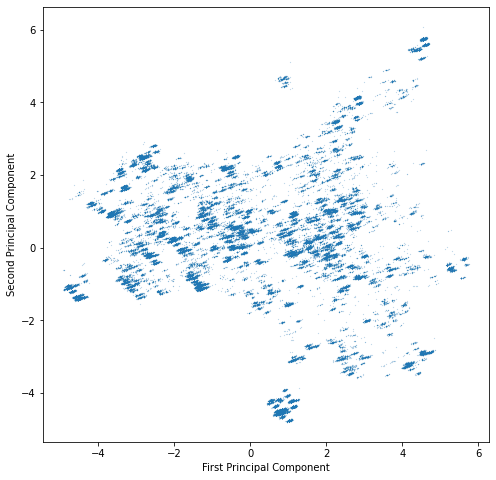

In [38]:
plt.figure(figsize=(8,8))
plt.scatter(x_pca[:,0],x_pca[:,1], s=0.01)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

We can see that the messages generally appear in streaks with a fairly uniform slope. Since most of the data about each message pertains to the sender of the message, we could imagine that each continuous streak corresponds to messages sent from one sender. The variations in the x and y axis can be attributed to information about the messages themselves.

The only such information is the information pertaining to the month and the year in which the message was sent, as well as the sentiment and the length of the message. The length of the message practically does not affect either of the principal components.

Some of the date information is weighted substantially enough to possibly cause a jump to another streak for the same sender - for instance, when `2015` changes to `2016`.

We also note that the streaks seem to all be capped at a certain length. Perhaps this is because the month, year and sentiment values have specific ranges that cannot be surpassed. Therefore, a change in sentiment, for example, leads to a small positive change in both principal components, causing a positive slope.

### Machine Learning

Now let's try to see how well we can ***predict whether a message has been sent by me or by another sender***. We can expect this data set to be fairly well balanced, because roughly half of the messages should be sent by me.

We will do this by using an **artificial neural network**. First let's explore the data set with this classification goal in mind.

Let's take a look at what features we are using.

In [98]:
df.columns.tolist()

['sender_name',
 'timestamp_ms',
 'content',
 'conversation',
 'reactions',
 'day',
 'date',
 'time',
 'entered_college',
 'sentiment',
 'academic standing',
 'first message',
 'relative standing',
 'semester',
 'length',
 'waited',
 'new talk',
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 'month__1',
 'month__2',
 'month__3',
 'month__4',
 'month__5',
 'month__6',
 'month__7',
 'month__8',
 'month__9',
 'month__10',
 'month__11',
 'month__12',
 'applied math',
 'biology',
 'chemistry',
 'computer engineering',
 'cs',
 'electrical engineering',
 'engineering',
 'finance',
 'health science',
 'humanities',
 'law',
 'math',
 'media',
 'medical',
 'nursing',
 'pharmacy',
 'physics',
 'met_at__baruch',
 'met_at__bay academy',
 'met_at__brooklyn tech',
 'met_at__graduated',
 'met_at__nyu',
 'met_at__self',
 'met_at__stony brook',
 'meeting_semester__0',
 'meeting_semester__1',
 'meeting_semester__2',
 'meeting_semester__3',
 'meeting_semester__4',
 'meeting_semester__5',
 'meeting_seme

We can get rid of the **`date`** column, because we have already extracted information from this column into the `day`, `month` and `year` columns.
Likewise, we can get rid of the **`timestamp_ms`** column.

We can also get rid of the **`sender_name`**, **`content`**, **`conversation`**, **`reactions`** and **`semester`** columns, although before dropping the **`sender_name`** we will create a new column indicating whether I am the sender.

We also want to drop **`academic standing`**, because it will not add any new information to the model. We would only use it to determine if the sender is of my academic year, which is known from **`relative standing`**.

We want to extract additional information out of **`time`** and **`waited`** columns, so that we have numerical features for our neural network model. Fortunately, we can extract data that is naturally ordered from these string values. Because some of the `waited` values are NaN, we make sure to replace that NaN values with 0, since these values correspond to taking initiative and starting a conversation.

Let's do these operations on a copy of the original dataframe.

In [99]:
df_1 = df.drop(['date', 'time', 'waited', 'timestamp_ms', 'content', 'conversation', 'reactions', 'semester', 'academic standing'], axis=1)

df_1['time_hour'] = df['time'].apply(lambda time: time[:2])
df_1['time_minute'] = df['time'].apply(lambda time: time[3:5])

df_1['waited_days'] = df['waited'].apply(lambda waited: waited.split(' ')[0] if (type(waited) == str) else np.nan_to_num(waited))
df_1['waited_hours'] = df['waited'].apply(lambda waited: waited.split(' ')[2][:2] if (type(waited) == str) else np.nan_to_num(waited))
df_1['waited_minutes'] = df['waited'].apply(lambda waited: waited.split(' ')[2][3:5] if (type(waited) == str) else np.nan_to_num(waited))

Now we will create a new column indicating whether a message has been sent by me or not.

After that, we will drop the **`sender_name`** column.

In [100]:
df_1['my_message'] = df['sender_name'].apply(lambda name: 1 if (name == my_name) else 0)

df_1.drop('sender_name', axis=1, inplace=True)

Now all of the features are ready to be used as input for a neural network.

Let's see how balanced the data is.

C:\Users\Denis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='my_message', ylabel='count'>

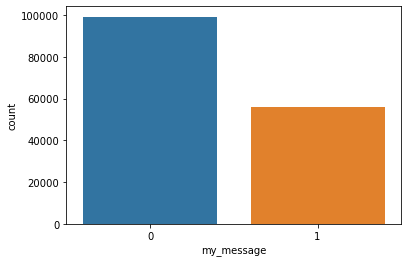

In [42]:
sns.countplot('my_message', data=df_1)

We can see that around a third of the messages in this data set are sent by me. Because the data set is significantly large, we can expect our predictions to be fairly accurate with this ratio.

Let's look at how different features correlate with **`my_message`**.

In [101]:
df_1.corr()['my_message'].sort_values()

met_at__stony brook      -0.491566
meeting_semester__1      -0.458655
lives_in_LI              -0.379490
met_at__baruch           -0.360867
meeting_semester__3      -0.333741
                            ...   
lives_in_NYC              0.535257
cs                        0.650907
met_at__self              1.000000
meeting_semester__self    1.000000
my_message                1.000000
Name: my_message, Length: 63, dtype: float64

Two features (**`meeting_semester__self`** and **`met_at__self`**) perfectly correlate with **`my_message`**, so we will drop these values, as they already identify the sender as me, a priori.

In [102]:
df_1.drop(['meeting_semester__self', 'met_at__self'], axis=1, inplace=True)

Now we can make an **artificial neural network** to predict whether a message has been sent by me or not.

We'll begin by selecting our ***testing*** and our ***training*** data.

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
X = df_1.drop(['my_message'], axis=1).values
y = df_1['my_message'].values

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Now we will ***normalize*** the **`X_train`** and the **`X_test`**.

In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [49]:
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

Now we can begin to create the actual **neural network model**.

We will structure it with one hidden layer, which contains a number of nodes equal to the average of the input and the output layers.

In [50]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25, min_delta=0.0001)

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [52]:
model = Sequential()

model.add(Dense(71, activation='relu'))

model.add(Dense(36, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy')

In [53]:
model.fit(x=X_train, y=y_train, batch_size=256, epochs=200, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/200
424/424 [==============================] - 3s 6ms/step - loss: 0.1692 - val_loss: 5.8351e-04
Epoch 2/200
424/424 [==============================] - 1s 2ms/step - loss: 4.2773e-04 - val_loss: 1.4496e-04
Epoch 3/200
424/424 [==============================] - 1s 2ms/step - loss: 1.0629e-04 - val_loss: 6.0099e-05
Epoch 4/200
424/424 [==============================] - 1s 2ms/step - loss: 5.0872e-05 - val_loss: 3.1868e-05
Epoch 5/200
424/424 [==============================] - 1s 2ms/step - loss: 2.6243e-05 - val_loss: 1.8799e-05
Epoch 6/200
424/424 [==============================] - 1s 2ms/step - loss: 1.6798e-05 - val_loss: 1.1936e-05
Epoch 7/200
424/424 [==============================] - 1s 2ms/step - loss: 9.5087e-06 - val_loss: 8.1688e-06
Epoch 8/200
424/424 [==============================] - 1s 2ms/step - loss: 6.8049e-06 - val_loss: 5.6774e-06
Epoch 9/200
424/424 [==============================] - 1s 2ms/step - loss: 4.8070e-06 - val_loss: 4.0951e-06
Epoch 10/200
424/424 [=

In [54]:
predictions = model.predict_classes(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, predictions))

C:\Users\Denis\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29760
           1       1.00      1.00      1.00     16737

    accuracy                           1.00     46497
   macro avg       1.00      1.00      1.00     46497
weighted avg       1.00      1.00      1.00     46497



We can see that the predictions are accurate with concrete examples.

In [55]:
df_1.iloc[78]['my_message']

1

In [56]:
cust = df_1.iloc[78].drop('my_message').values.reshape(1,71)
cust = scaler.transform(cust)
prediction = model.predict_classes(cust)
prediction

C:\Users\Denis\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1]])

### New model

Now let's try to develop a **new model** for predicting whether a message has been sent by me.

In [103]:
for feature in df_1.corr()['my_message'].keys():
    if (df_1.corr()['my_message'][feature] < 0.2) and (df_1.corr()['my_message'][feature] > -0.2):
        df_1.drop(feature, axis=1, inplace=True)

Text(0, 0.5, 'Second Principal Component')

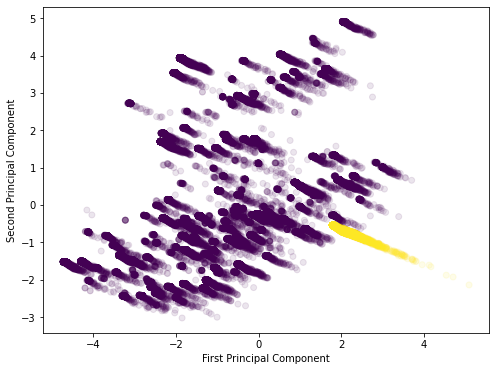

In [59]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_1.drop('my_message', axis=1))

scaled_data = scaler.transform(df_1.drop('my_message', axis=1))

from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca.fit(scaled_data)

x_pca = pca.transform(scaled_data)

plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1], c=df_1['my_message'], alpha=0.1)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

<AxesSubplot:>

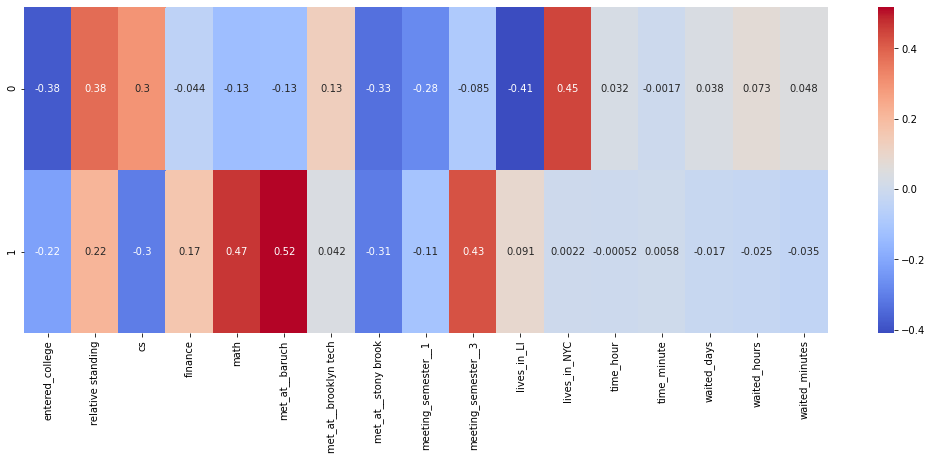

In [105]:
df_comp = pd.DataFrame(pca.components_, columns=df_1.drop('my_message', axis=1).columns)

plt.figure(figsize=(18,6))
sns.heatmap(df_comp,cmap='coolwarm', annot=True)

We can notice that most of the features are constant for each sender, so the only variation per sender is in the `time_` and `waited_` features. this means that each downward streak corresponds to a single sender, where the first and second principle components have weights of opposite signs associated with each of the `time_` and `waited_` components.

If we drop those components, we would expect to see all points corresponding to each sender appearing at the same place in the graph.

Text(0, 0.5, 'Second Principal Component')

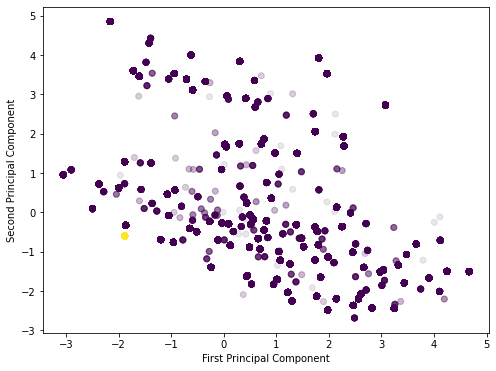

In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_1.drop(['my_message', 'time_hour', 'time_minute', 'waited_days', 'waited_hours', 'waited_minutes'], axis=1))

scaled_data = scaler.transform(df_1.drop(['my_message', 'time_hour', 'time_minute', 'waited_days', 'waited_hours', 'waited_minutes'], axis=1))

pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1], c=df_1['my_message'], alpha=0.1)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

Indeed, my messages appear at only a single point. My point is uniquely identified because, although I have excluded information such as `met_at__self`, I am not marked as having met myself at either Brookyln Tech, Baruch, Stony Brook or NYU. This distribution is unique to me.

<AxesSubplot:>

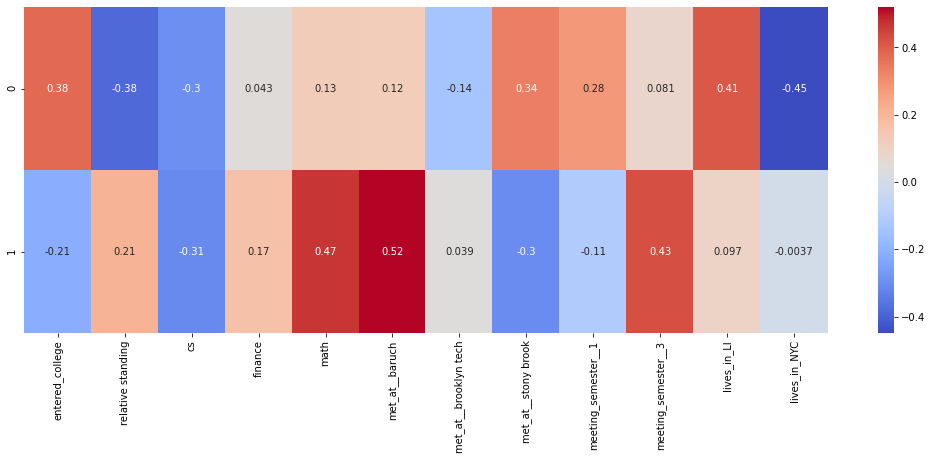

In [107]:
df_comp = pd.DataFrame(pca.components_, columns=df_1.drop(['my_message', 'time_hour', 'time_minute', 'waited_days', 'waited_hours', 'waited_minutes'], axis=1).columns)

plt.figure(figsize=(18,6))
sns.heatmap(df_comp,cmap='coolwarm', annot=True)

In [63]:
me = df_1.iloc[78]


weights_0 = pca.components_[0]
weighted_0 = me.drop(['my_message', 'time_hour', 'time_minute', 'waited_days', 'waited_hours', 'waited_minutes']) * weights_0
my_component_0 = weighted_0.sum()

weights_1 = pca.components_[1]
weighted_1 = me.drop(['my_message', 'time_hour', 'time_minute', 'waited_days', 'waited_hours', 'waited_minutes']) * weights_1
my_component_1 = weighted_1.sum()

print(my_component_0, my_component_1)

700.4833588837577 -390.0002756713641


Above, I printed out the coordinates of my point on the graph. I can now make a function that can classify any message as either my message or not.

In [64]:
def me_tester(message):
    weights_0 = pca.components_[0]
    weighted_0 = message.drop(['my_message', 'time_hour', 'time_minute', 'waited_days', 'waited_hours', 'waited_minutes']) * weights_0
    component_0 = weighted_0.sum()

    weights_1 = pca.components_[1]
    weighted_1 = message.drop(['my_message', 'time_hour', 'time_minute', 'waited_days', 'waited_hours', 'waited_minutes']) * weights_1
    component_1 = weighted_1.sum()
    
    if component_0 == my_component_0 and component_1 == my_component_1:
        print("This is my message")
    else:
        print("This is not my message")

In [65]:
me_again = df_1.iloc[140]

me_tester(me_again)

This is my message


This function works successfully.

Essentially, I used principal component analysis to reduce all messages sent by a single sender to a single point. This mapping is not bijective, because it is based on a set of parameters that do not uniquely identify a sender. As I have mentioned before, my approach to classification worked because the dataframe was already geared towards classifying messages as mine or not, by virtue of my having had a feature for `met_at__self`. This feature was not independent of the other `met_at` features, so it allowed me to uniquely identify messages as mine or not.

Although I did not include `met_at__NYU` in the calculation of the principal components, I did not know any NYU computer science majors, so there is no possibility of an identical mapping to my point from an NYU student.

Is using only `met_at__Brooklyn Tech`, `met_at__Baruch` and `met_at__Stony Brook` sufficient for this model to work with this data set?

Text(0, 0.5, 'Second Principal Component')

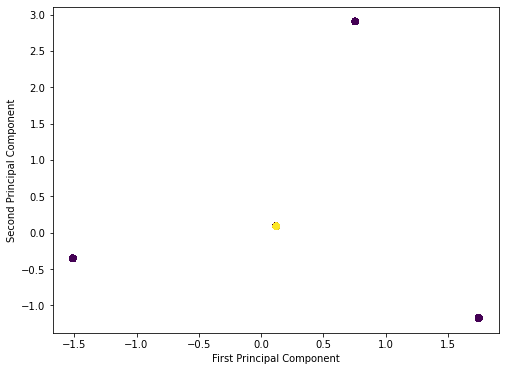

In [66]:
scaler.fit(df_1[['met_at__brooklyn tech', 'met_at__baruch', 'met_at__stony brook']])

scaled_data = scaler.transform(df_1[['met_at__brooklyn tech', 'met_at__baruch', 'met_at__stony brook']])

pca = PCA(n_components=2)

pca.fit(scaled_data)

x_pca = pca.transform(scaled_data)

plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1], c=df_1['my_message'])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

Here we see that the messages collapse into four points. This could seem surprising at first. After all, I could have met the sender at *brooklyn tech*, *baruch*, *stony brook*, *nyu*, or *self*.

We realize, however, that the principal components do not factor in `met_at__nyu` and `met_at__self`, so the principal component model is oblivious of those features. Therefore, all of the *nyu* and *self* messages are collapsed into the point at the center.

We can no longer use this point to classify the messages as sent from me, because now NYU messages are all collapsed into the same point. This explains the purple pixels emerging behind the yellow point on the graph.

Using the fact that I am identified as a `cs` major in this dataset and that I do not know CS majors whom I met at NYU, I can add the `cs` feature to the principal component model, thus creating a working classification model.

Text(0, 0.5, 'Second Principal Component')

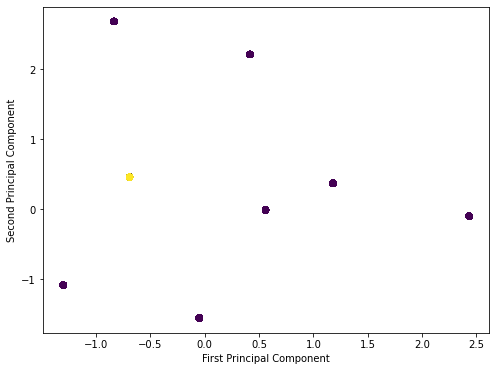

In [67]:
scaler.fit(df_1[['met_at__brooklyn tech', 'met_at__baruch', 'met_at__stony brook', 'cs']])

scaled_data = scaler.transform(df_1[['met_at__brooklyn tech', 'met_at__baruch', 'met_at__stony brook', 'cs']])

pca = PCA(n_components=2)

pca.fit(scaled_data)

x_pca = pca.transform(scaled_data)

plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1], c=df_1['my_message'])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

Now we will reset the values of **`my_component_0`** and **`my_component_1`** and then we will run the test for my messages again.

In [71]:
me = df_1.iloc[78]


weights_0 = pca.components_[0]
weighted_0 = me[['met_at__brooklyn tech', 'met_at__baruch', 'met_at__stony brook', 'cs']] * weights_0
my_component_0 = weighted_0.sum()

weights_1 = pca.components_[1]
weighted_1 = me[['met_at__brooklyn tech', 'met_at__baruch', 'met_at__stony brook', 'cs']] * weights_1
my_component_1 = weighted_1.sum()
    
print(my_component_0, my_component_1)

-0.6199983697490614 0.23239742004410543


In [72]:
def me_tester(message):
    weights_0 = pca.components_[0]
    weighted_0 = message[['met_at__brooklyn tech', 'met_at__baruch', 'met_at__stony brook', 'cs']] * weights_0
    component_0 = weighted_0.sum()

    weights_1 = pca.components_[1]
    weighted_1 = message[['met_at__brooklyn tech', 'met_at__baruch', 'met_at__stony brook', 'cs']] * weights_1
    component_1 = weighted_1.sum()
    
    if component_0 == my_component_0 and component_1 == my_component_1:
        print("This is my message")
    else:
        print("This is not my message")

In [73]:
me_again = df_1.iloc[140]

me_tester(me_again)

This is my message


Now we have another working classification model, using a peculiarity of the data set to quickly do classification.